In [1]:
# add ../product_fem to path
import sys
sys.path.append(sys.path[0] + '/..')

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from product_fem import product_fem as pf
from product_fem.equations import DriftDiffusion
from fenics import *

## Drift-diffusion equation with sinusoidal analytic solution

Here we consider 

$$
\begin{align*}
    -\varepsilon\Delta u + \mathbf b \cdot \nabla u &= f \quad \mathrm{in}\, \Omega \\
    u(x,y) &= \sin(x)\sin(y)\quad \mathrm{on} \,\partial\Omega
\end{align*}
$$

when $\mathbf{b}(x,y) = (x, y)^T$ and 
$f(x,y) = 2\varepsilon\sin(x)\sin(y) + x \cos(x)\sin(y) + y \sin(x) \cos(y)$.
the analytic solution is $u(x,y) = \sin(x)\sin(y)$.
As long as $\mathbf b(x,y) = (b_1(x), b_2(y))^T$
the weak solution $u_h$ satisfies $Au_h = b$ where

$$
A_{ij,k\ell} = 
\varepsilon\int\! \phi_k'\hat\phi_i' \,dx
\int\! \phi_\ell\hat\phi_j \,dy 
+
\varepsilon\int\! \phi_k\hat\phi_i \,dx
\int\! \phi_\ell'\hat\phi_j' \,dy 
+
\int\! b_1\phi_k'\hat\phi_i \,dx
\int\! \phi_\ell\hat\phi_j \,dy
+
\int\! \phi_k\hat\phi_i \,dx
\int\! b_2\phi_\ell'\hat\phi_j \,dy
$$

and $b_{ij} = \sum_k\int\! X_k\hat\phi_i \,dx \int\! Y_k\hat\phi_j \,dy$
where $f(x,y) = \mathbf X(x) \cdot\mathbf Y(y)$.
In this case, 
$$\begin{align*}
    \mathbf X(x) &= (2\varepsilon\sin(x), x\cos(x), \sin(x))^T\\
\mathbf Y(y) &= (\sin(y), \sin(y), y\cos(y))^T
\end{align*}$$

In [10]:
def forward_solve(n, eps, error=False):
    # set up function space
    mesh = UnitIntervalMesh(n-1)
    h = mesh.hmax()
    V = FunctionSpace(mesh, 'CG', 1)
    W = pf.ProductFunctionSpace(V)

    # drift coefs
    b = ['x[0]', 'x[0]']

    # force function f = sum_i X_iY_i
    X = ['2 * eps * sin(x[0])', 'x[0] * cos(x[0])', 'sin(x[0])']
    X = [Expression(x, element=V.ufl_element(), eps=eps) for x in X]
    Y = ['sin(x[0])', 'sin(x[0])', 'x[0] * cos(x[0])']
    Y = [Expression(y, element=V.ufl_element()) for y in Y]
    f = (X, Y)

    # boundary conditions
    u_bdy = lambda x, y: np.sin(x) * np.sin(y)
    bc = pf.ProductDirichletBC(W, u_bdy, 'on_boundary')

    # fem solution
    dd = DriftDiffusion(W, f, bc)
    u_h = dd.solve(eps, b)

    # analytic solution
    u = pf.ProductFunction(W)
    u.assign(u_bdy)
    u = u.array
    L2_error = np.sqrt(W.integrate((u - u_h)**2))
    
    if error:
        return h, L2_error
    else:
        return u_h

<AxesSubplot:>

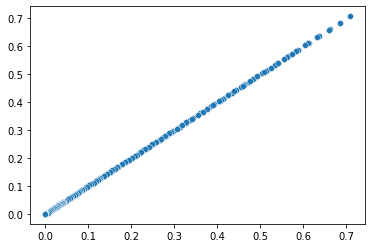

In [11]:
# set up function space
mesh = UnitIntervalMesh(20)
h = mesh.hmax()
V = FunctionSpace(mesh, 'CG', 1)
W = pf.ProductFunctionSpace(V)

# drift coefs
eps = 1
b = ['x[0]', 'x[0]']

# force function f = sum_i X_iY_i
X = ['2 * eps * sin(x[0])', 'x[0] * cos(x[0])', 'sin(x[0])']
X = [Expression(x, element=V.ufl_element(), eps=eps) for x in X]
Y = ['sin(x[0])', 'sin(x[0])', 'x[0] * cos(x[0])']
Y = [Expression(y, element=V.ufl_element()) for y in Y]
f = (X, Y)

# boundary conditions
u_bdy = lambda x, y: np.sin(x) * np.sin(y)
bc = pf.ProductDirichletBC(W, u_bdy, 'on_boundary')

# fem solution
dd = DriftDiffusion(W, f, bc)
u_h = dd.solve(eps, b)

# analytic solution
u = pf.ProductFunction(W)
u.assign(u_bdy)
u = u.array

x = [i for i in range(len(u_h))]
sns.scatterplot(x=u, y=u_h)
# sns.lineplot(x=x, y=u)

In [12]:
def mesh_convergence(eps=1):
    # organize data frame
    ns = [6, 11, 21, 41]
    h_errors = np.array([forward_solve(n, eps=eps, error=True) for n in ns])
    hs, l2_err = h_errors[:,0], h_errors[:,1]
    data = {'n': ns, 'h': hs, 'log_h': np.log(hs), 'l2_err': l2_err, 'log_l2_err': np.log(l2_err)}
    data = pd.DataFrame(data)

    # perform regression and plot
    slope, intercept, r, p, se = stats.linregress(data['log_h'], data['log_l2_err'])
    line_kws={'label':fr'$\log(\parallel u - u_h\parallel_2) = {np.round(slope, 4)} \log(h) + {np.round(intercept, 1)}$'}
    ax = sns.regplot(x='log_h', y='log_l2_err', data=data, 
                     ci=None, order=1, line_kws=line_kws)
    # aesthetics
    ax.figure.set_dpi(100)
    ax.figure.set_figheight(6)
    ax.figure.set_figwidth(6)
    ax.set_xlabel(r'$\log(h)$')
    ax.set_ylabel(r"$ log(\parallel u - u_h\parallel_2)$")
    ax.set_title(fr'$r^2 = {r**2}$')
    ax.legend()
    plt.show()

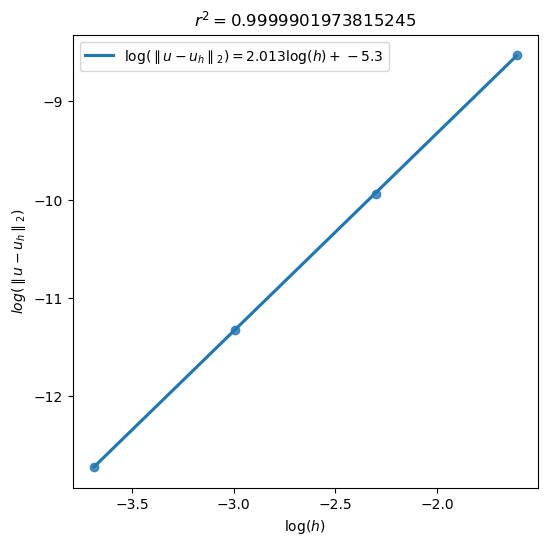

In [13]:
mesh_convergence(1)

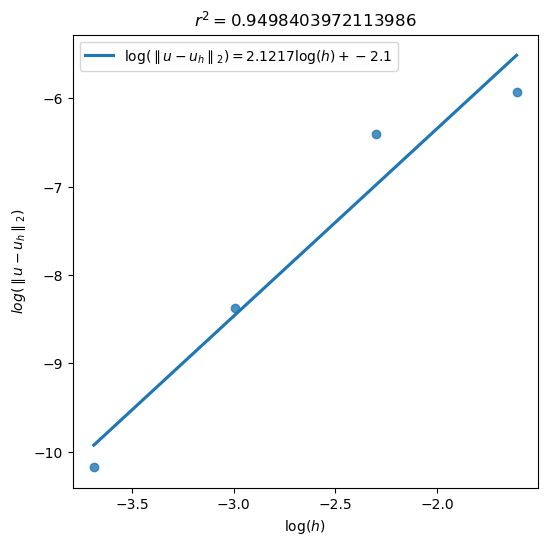

In [17]:
mesh_convergence(1e-3)

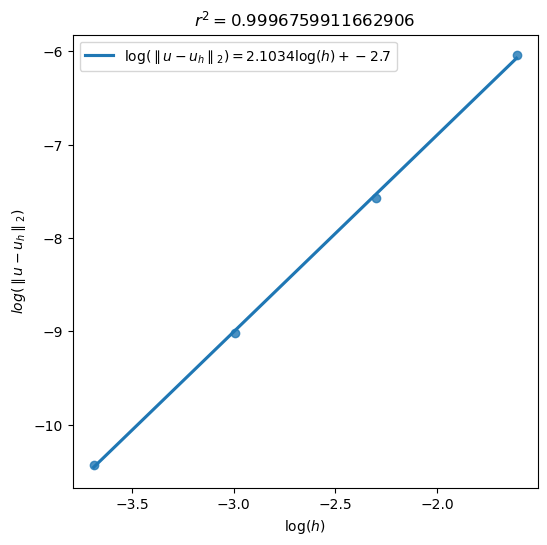

In [16]:
mesh_convergence(1e-6)